# Model the epistemic uncertainty

In [1]:
import numpy as np 
import pandas as pd 
from scipy.special import softmax

import torch
from torch.distributions import Normal, Beta

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys 
sys.path.append("..") 
from utils.agent import *
from utils.viz import viz 
from utils.model import model 
viz.get_style()

## 1. The epistemic uncertainty


$$\pi(a|m)= \int \pi(a|\theta,m)p(\theta)d\theta$$

Classic RL model 

$$
\begin{aligned}
\pi(a|m)
=&\int \pi(a|\theta,m)p(\theta)d\theta\\
\approx& \int \pi(a|\theta,m)\delta(\theta^*)d\theta \\
=& \pi(a|\theta^*,m)
\end{aligned}
$$

Distributed model

$$
\begin{aligned}
\pi(a|m)
=& \int \pi(a|\theta,m)p(\theta)d\theta \\
\approx & \frac{1}{N}\sum_{i=1}^N \pi(a|\theta^{(i)},m)
\end{aligned}
$$



![Image](https://pic4.zhimg.com/80/v2-4b229aabfc49fdaca981f65919d1550e.png)

### 1.3 the model architecture

In [2]:
# free parameters
log0  = [10, 10]
alpha = .1
o, nA = 1, 2

m1, m2 = 87, 28
N = 1000

# prior parameters
loga = (torch.ones([1])*log0[0]).requires_grad_()
logb = (torch.ones([1])*log0[1]).requires_grad_()
a = loga.exp()
b = logb.exp()
mag = torch.tensor([m1, m2])

# sample the weights for bernoulli
theta = Beta(a, b).rsample([N,])
print(f'θ dim: ', theta.shape)

# get the log variational posterior 
log_post = Beta(a.detach(), b.detach()).log_prob(theta).mean()
print(f'∑i log p(θi|a,b): ', log_post)

# get the log like: olog(θ) + (1-o)log(1-θ)
log_like = (o*(theta+eps_).log() + (1-o)*(1-theta+eps_).log()).mean()
print(f'∑i log p(D|θi): ', log_like)

θ dim:  torch.Size([1000, 1])
∑i log p(θi|a,b):  tensor(4.6033, grad_fn=<MeanBackward0>)
∑i log p(D|θi):  tensor(-0.6933, grad_fn=<MeanBackward0>)


In [3]:
loss = log_post - log_like
loss.backward()

print(loga.grad.data, logb.grad.data)

loga.data -= alpha * loga.grad.data
logb.data -= alpha * logb.grad.data
loga.grad.data.zero_()
logb.grad.data.zero_()

tensor([2.8018]) tensor([-2.3077])


/home/zfang/anaconda3/envs/py3/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


tensor([0.])

### 1.3 the model behaviors (simulation)

In [4]:
def get_data(sub_id):
    data = pd.read_csv(f'../data/exp1_all.csv')
    return data.query(f'sub_id=="{sub_id}"').reset_index()


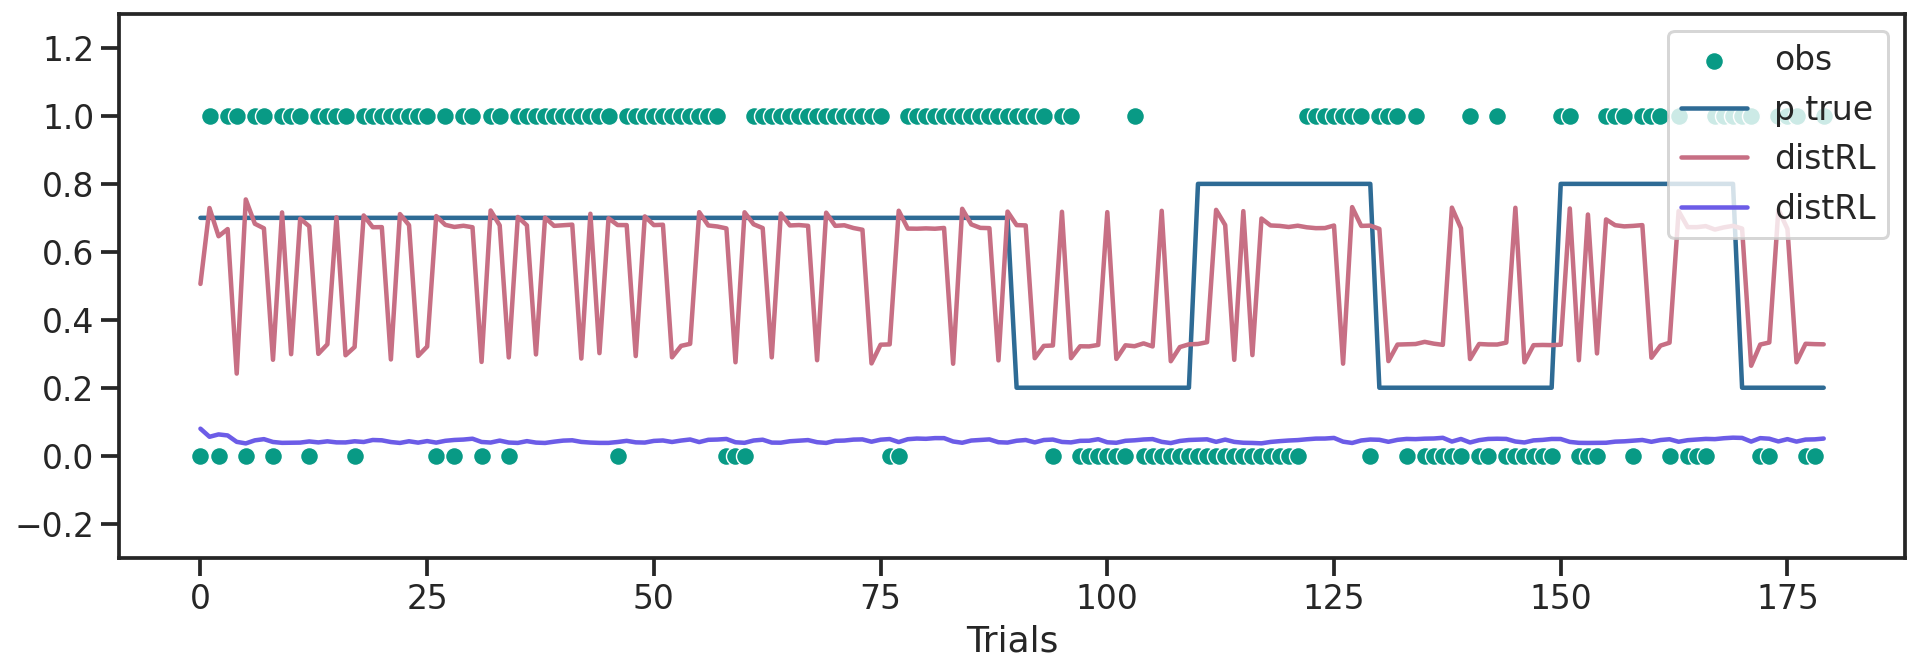

In [6]:
subj_data = {1: get_data('n35')}
torch.random.manual_seed(42)
rng =np.random.RandomState(123)
subject  = model(distRL)
params = [.6, 5, .1]
sim_data = subject.sim(subj_data, params, rng)
fig,ax=plt.subplots(1,1,figsize=(16, 5))
sns.scatterplot(x='trial', y='act', data=sim_data, 
            marker='o', color=viz.Green, 
            ax=ax, label='obs')
sns.lineplot(x='trial', y='p_true', data=sim_data, 
            color=viz.Blue, 
            ax=ax, label='p true')
sns.lineplot(x='trial', y='ps', data=sim_data, 
            color=viz.Red, 
            ax=ax, label='distRL')
sns.lineplot(x='trial', y='vars', data=sim_data, 
            color=viz.Purple, 
            ax=ax, label='distRL')

ax.set_ylim([-.3, 1.3])
ax.set_ylabel('')
ax.set_xlabel('Trials')
ax.legend()
plt.show()

In [ ]:
subj_data = {1: get_data('n35')}
rng = np.random.default_rng(42)
subject  = model(mixNN2)
subject2 = model(mix)

params  = [0.0,0.7490629705637917,0.04975424306485403,5.190315613185698,0.0,0.5629760049410689,0.0]
params2 = [0.0,0.7490629705637917,0.04975424306485403,5.190315613185698,0.0,0.5629760049410689,0.0]
sim_data = subject.sim(subj_data, params, rng)
sim_data2 = subject2.sim(subj_data, params2, rng)
fig,ax=plt.subplots(1,1,figsize=(16, 5))
sns.scatterplot(x='trial', y='act', data=sim_data, 
            marker='o', color=viz.Green, 
            ax=ax, label='obs')
sns.lineplot(x='trial', y='p_true', data=sim_data, 
            color=viz.Blue, 
            ax=ax, label='p true')
sns.lineplot(x='trial', y='ps', data=sim_data, 
            color=viz.Red, 
            ax=ax, label='mixNN')
sns.lineplot(x='trial', y='ps', data=sim_data2, 
            color=viz.Yellow, 
            ax=ax, label='mix')

ax.set_ylim([-.3, 1.3])
ax.set_ylabel('')
ax.set_xlabel('Trials')
ax.legend()
plt.show()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(16, 5))
sns.scatterplot(x='trial', y='act', data=sim_data, 
            marker='o', color=viz.Green, 
            ax=ax, label='obs')
sns.lineplot(x='trial', y='p_true', data=sim_data, 
            color=viz.Blue, 
            ax=ax, label='p true')
sns.lineplot(x='trial', y='pi', data=sim_data, 
            color=viz.Red, 
            ax=ax, label='mixNN2')
sns.lineplot(x='trial', y='pi', data=sim_data2, 
            color=viz.Yellow, 
            ax=ax, label='mix')
ax.set_ylim([-.3, 1.3])
ax.set_ylabel('')
ax.set_xlabel('Trials')
ax.legend()
plt.show()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(16, 5))
sns.scatterplot(x='trial', y='state', data=sim_data, 
            marker='o', color=viz.Green, 
            ax=ax, label='obs')
sns.scatterplot(x='trial', y='act', data=sim_data, 
            marker='o', color=viz.Red, 
            ax=ax, label='obs')
sns.lineplot(x='trial', y='pi', data=sim_data2, 
            color=viz.Red, 
            ax=ax, label='distRL')
sns.lineplot(x='trial', y='pi', data=sim_data2, 
            color=viz.Yellow, 
            ax=ax, label='mixNN')
ax.set_ylim([-.3, 1.3])
ax.set_ylabel('')
ax.set_xlabel('Trials')
ax.legend()
plt.show()

Tomorrow

1. Do I implemented the correct neural network?
2. Why sig does not work?
3. 

In [ ]:

sns.barplot(x='act', y='mag1', data=sim_data, 
            palette=viz.Palette, hue='b_type')
plt.show()

In [ ]:
import statsmodels.api as sm
X = sim_data2[["ps", "mag1"]]
y = sim_data2["act"]
model = sm.OLS(y, X).fit()
model.summary()